# Lab 10.Eng2 
## Text Generation through Bidirectional LSTM model

<table class="tfo-notebook-buttons" align="left">
   <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/hongsukyi/rnn-nlp-lectures/blob/main/lec11-text-generation/lab11-eng2-textGen-LSTM2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>



## 1) Bidirectional LSTMs

Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems. 

They train the model forward and backward on the same input (so for 1 layer LSTM we get 2 hidden and cell states)
- First from left to right on the input sequence and the second in reversed order of the input sequence. 

### Now let’s see how to implement this model in text generation.

Import the following libraries:

In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical, plot_model


In [5]:
print(tf.__version__)

2.7.0


## 2) Text pre-processing

- In this, the whole text is cleaned and converted to lower case and the whole corpus of sentences are joined. 
- Words are then tokenized

In [3]:
tokenizer = Tokenizer()

In [6]:
# Colab에서 데이터 파일 읽기

from google.colab import files 
myfile = files.upload()

Saving tiny-shakespeare.txt to tiny-shakespeare.txt


In [7]:
data = open('./tiny-shakespeare.txt').read()

In [8]:
len(data)

1115394

In [9]:
data=data[:10000]

In [ ]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
print(tokenizer.word_index)

In [ ]:
print(corpus[:15])

In [11]:
total_words = len(tokenizer.word_index) + 1
print('total_words=',total_words)

total_words= 672


## 3) Creating Sequences

For each word, an n-gram sequence is made and input sequences are updated. It happens in the iteration for the next word and so on.

- For example, in the sentence below first 'He’ was extracted out then, ‘He was ’ was extracted, and then ‘He was walking ’ was extracted, and so on.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [12]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)        

### Padding sequences

- The maximum length of the sentence is extracted and then the rest of the sentences are pre-padded as per the longest sentence.

In [13]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, 
                                         padding='pre'))

In [14]:
print('max_len', max_sequence_len)
print('total-words',total_words)

max_len 12
total-words 672


### Label
Extract the last word of sequence and convert it to categorical from numerical.

In [15]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)

## 4) Bidirectional LSTM Model
- Let’s make a sequential model now with the first layer as the word embedding layer.
- __'return_sequence'__ is marked as __True__ so that the word generation keeps in consideration, previous and even the words coming ahead in the sequence.

- The output layer has softmax so as to get the probability of the word to be predicted next.

In [16]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu' ))
model.add(Dense(total_words, activation='softmax'))

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 100)           67200     
                                                                 
 bidirectional (Bidirectiona  (None, 11, 300)          301200    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 336)               33936     
                                                                 
 dense_1 (Dense)             (None, 672)               226464    
                                                                 
Total params: 789,200
Trainable params: 789,200
Non-trainable params: 0
__________________________________________________

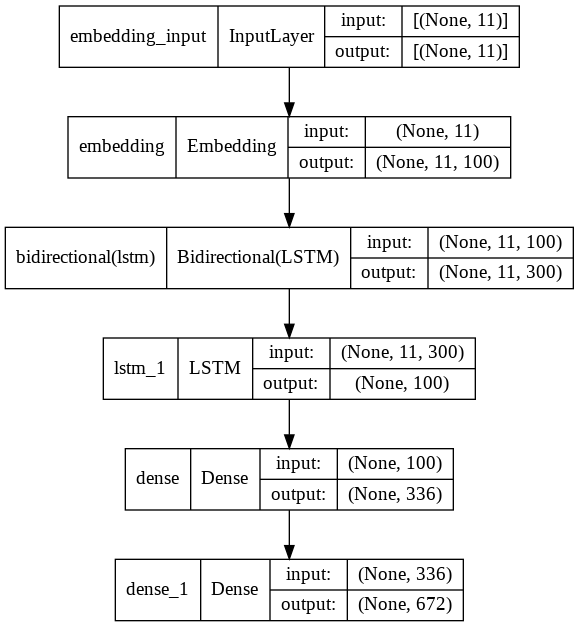

In [18]:
plot_model(model, './fig_lab10_eng2.png', show_shapes=True)

In [19]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
import time
start = time.perf_counter()

The Elapse time for a single CPU is for 100 epochs:: 
 Elapsed 230.794 seconds.

In [22]:
import time
start = time.perf_counter()
history = model.fit(predictors, label, epochs=100, verbose=1)
elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
47/47 [==============================] - 1s 21ms/step - loss: 6.2476 - accuracy: 0.0552
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 5.8537 - accuracy: 0.0585
Epoch 3/100
47/47 [==============================] - 1s 21ms/step - loss: 5.7601 - accuracy: 0.0578
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 5.5926 - accuracy: 0.0632
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 5.4405 - accuracy: 0.0791
Epoch 6/100
47/47 [==============================] - 1s 21ms/step - loss: 5.3015 - accuracy: 0.0751
Epoch 7/100
47/47 [==============================] - 1s 21ms/step - loss: 5.1810 - accuracy: 0.0811
Epoch 8/100
47/47 [==============================] - 1s 21ms/step - loss: 5.0729 - accuracy: 0.0818
Epoch 9/100
47/47 [==============================] - 1s 21ms/step - loss: 4.9701 - accuracy: 0.0891
Epoch 10/100
47/47 [==============================] - 1s 21ms/step - loss: 4.8093 - accuracy: 0.0884

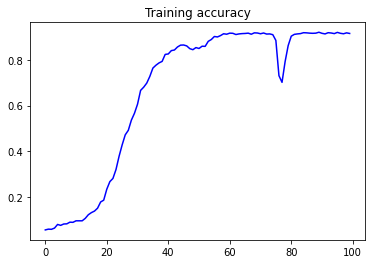

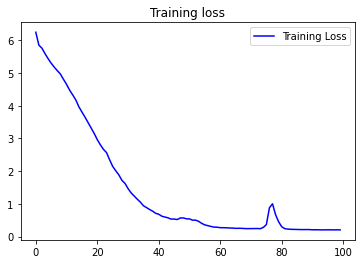

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

## 5) Test for the next generation. 
- 100 next words are generated this way.

In [24]:
seed_text = "First Servingman: A strange one as ever I looked on: I cannot get him!"
next_words = 100

- The seed will be taken at first and tokenized and padded on the token list. 
- Model is then used to predict with the token list as input.
- Then most probable word is added to seed text and this happens for the next 100 words.

In [25]:
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    p_x = model.predict(token_list, verbose=0)
    predicted=np.argmax(p_x,axis=1)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

First Servingman: A strange one as ever I looked on: I cannot get him! their liking mark me say a rightly heard it did he a heard which he a price away price price away away away ye price price price ye price price price ye price price price away away ye price price price ye price price price price away proverbs proverbs covetous covetous covetous covetous it like away proverbs say it like fathers covetous he a price price price away away away away he a price price price away away away away away say he a price price price price away answer'd he a price mark me them not will flatter it


## 6) HW : Optimized Model Architecture
- The output is not perfect as for training we took only a few lines of text. 
- Hence we can very well fine-tune it.

- For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

- To generate more convincing text, you could try using more GRU layers and more neurons per layer, train for longer, and add some regularization (for example, you could set recurrent_dropout=0.3 in the GRU layers).

![image.png](attachment:image.png)

In [26]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(GRU(150, return_sequences = True)))
model.add(GRU(100))
model.add(Dense(total_words/2, activation='relu' ))
model.add(Dense(total_words, activation='softmax'))

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
import time
start = time.perf_counter()
history = model.fit(predictors, label, epochs=100, verbose=1)
elapsed = time.perf_counter() - start
print('============================\n Elapsed %.3f seconds.' % elapsed)

Epoch 1/100
47/47 [==============================] - 5s 20ms/step - loss: 6.2640 - accuracy: 0.0419
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 5.8620 - accuracy: 0.0585
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 5.6846 - accuracy: 0.0632
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 5.4855 - accuracy: 0.0751
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 5.2737 - accuracy: 0.0805
Epoch 6/100
47/47 [==============================] - 1s 20ms/step - loss: 5.0737 - accuracy: 0.0844
Epoch 7/100
47/47 [==============================] - 1s 20ms/step - loss: 4.8486 - accuracy: 0.0891
Epoch 8/100
47/47 [==============================] - 1s 20ms/step - loss: 4.5627 - accuracy: 0.1031
Epoch 9/100
47/47 [==============================] - 1s 20ms/step - loss: 4.2411 - accuracy: 0.1137
Epoch 10/100
47/47 [==============================] - 1s 19ms/step - loss: 3.8670 - accuracy: 0.1443